
# Pretrain Gold Feature Store — Audit Notebook

This notebook helps you **inspect and validate** the pretrain feature store built from Gold sources.

**What it checks**
- Load and preview the dataset for a given snapshot date
- Schema, counts, and head/tail samples
- Presence of expected columns (clickstream `fe_1_mean` … `fe_20_mean`)
- Null-rate summary by column
- Duplicate customers
- Date logic checks vs `label_snapshot_date` and **`mob` cut-off**
- Basic numeric stats & quick histograms
- Quick categorical summaries
- Sanity checks on ranges (e.g., `Interest_Rate` ≤ 100)


In [80]:
from pathlib import Path

# ==== CONFIG ====
SNAPSHOT_DATE = "2024-01-01"   # <-- change if needed
MOB           = 6              # months-on-books used for cutoff

# Paths (adjust if your layout differs)
ROOT = Path.cwd()                   # e.g., /home/jovyan/work
GOLD_PRETRAIN_DIR = ROOT / "scripts" / "datamart" / "pretrain_gold" / "features"
# parquet_path = PRETRAIN_DIR / f"gold_pretrain_feature_store_{date_token}.parquet"
GOLD_LABELS_DIR   = ROOT / "scripts" / "datamart" / "gold" / "labels"

# Spark app name
SPARK_APP_NAME = "pretrain-gold-audit"

# Number of rows to show in samples
N_SHOW = 20


In [81]:

import os
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql import Window
import glob

spark = (
    SparkSession.builder
    .appName(SPARK_APP_NAME)
    .master("local[*]")
    .getOrCreate()
)
spark.sparkContext.setLogLevel("ERROR")

print("Spark version:", spark.version)


Spark version: 3.5.0


In [82]:
print("CWD:", ROOT)
print("Listing", GOLD_PRETRAIN_DIR, ":")
for p in glob.glob(str(GOLD_PRETRAIN_DIR / "*.parquet")):
    print(" -", p)

CWD: /app
Listing /app/scripts/datamart/pretrain_gold/features :
 - /app/scripts/datamart/pretrain_gold/features/gold_pretrain_feature_store_2024_01_01.parquet


In [83]:

date_token = SNAPSHOT_DATE.replace("-", "_")
feat_path = os.path.join(GOLD_PRETRAIN_DIR, f"gold_pretrain_feature_store_{date_token}.parquet")
lab_path  = os.path.join(GOLD_LABELS_DIR,   f"gold_label_store_{date_token}.parquet")

print("Feature path:", feat_path)
print("Labels  path:", lab_path)

features_df = spark.read.parquet(feat_path)
labels_df   = spark.read.parquet(lab_path)

print("Features count:", features_df.count())
print("Labels count  :", labels_df.count())

features_df.printSchema()
labels_df.printSchema()


Feature path: /app/scripts/datamart/pretrain_gold/features/gold_pretrain_feature_store_2024_01_01.parquet
Labels  path: /app/scripts/datamart/gold/labels/gold_label_store_2024_01_01.parquet
Features count: 471
Labels count  : 471
root
 |-- Customer_ID: string (nullable = true)
 |-- label_snapshot_date: date (nullable = true)
 |-- Age_bin: string (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- attributes_snapshot_date: date (nullable = true)
 |-- Annual_Income: float (nullable = true)
 |-- Monthly_Inhand_Salary: float (nullable = true)
 |-- Num_Bank_Accounts: integer (nullable = true)
 |-- Num_Credit_Card: integer (nullable = true)
 |-- Num_of_Loan: integer (nullable = true)
 |-- Type_of_Loan: string (nullable = true)
 |-- Interest_Rate: float (nullable = true)
 |-- Delay_from_due_date: integer (nullable = true)
 |-- Num_of_Delayed_Payment: integer (nullable = true)
 |-- Num_Credit_Inquiries: integer (nullable = true)
 |-- Outstanding_Debt: float (nullable = true)
 |-- 

In [84]:

print("=== SAMPLE ROWS (features) ===")
display_df = features_df.limit(N_SHOW).toPandas()
display_df


=== SAMPLE ROWS (features) ===


,Customer_ID,label_snapshot_date,Age_bin,Occupation,attributes_snapshot_date,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Num_of_Loan,...,fe_11_mean,fe_12_mean,fe_13_mean,fe_14_mean,fe_15_mean,fe_16_mean,fe_17_mean,fe_18_mean,fe_19_mean,fe_20_mean
0,CUS_0x1130,2024-01-01,35_49,None,2023-07-01,137798.875000,10609.791992,6.0,NaN,0,...,94.86,82.43,134.71,121.29,152.43,139.57,118.57,90.43,101.00,84.14
1,CUS_0x11d1,2024-01-01,25_34,Mechanic,2023-07-01,11731.584961,828.632080,8.0,3.0,2,...,76.86,115.00,67.86,136.00,56.71,70.29,71.00,128.71,105.14,104.57
2,CUS_0x11eb,2024-01-01,None,None,2023-07-01,62835.078125,5464.256836,0.0,4.0,2,...,74.00,112.29,91.57,58.14,88.71,84.00,71.86,63.29,96.71,69.14
3,CUS_0x120c,2024-01-01,None,Scientist,2023-07-01,29135.380859,2138.948242,10.0,7.0,9,...,133.00,112.43,142.29,48.86,119.14,136.43,119.29,162.57,100.86,118.29
4,CUS_0x124a,2024-01-01,25_34,Developer,2023-07-01,16861.339844,1453.111694,2.0,6.0,3,...,106.43,72.14,23.00,83.14,68.71,90.43,194.71,97.29,107.43,83.57
5,CUS_0x12ce,2024-01-01,35_49,Accountant,2023-07-01,9795.070312,586.255859,7.0,8.0,6,...,87.29,118.71,112.86,89.71,84.14,85.14,88.57,112.71,108.00,135.00
6,CUS_0x13b0,2024-01-01,25_34,Entrepreneur,2023-07-01,73417.476562,6001.123535,7.0,4.0,4,...,60.86,90.43,48.00,60.00,56.14,150.71,63.00,116.57,54.29,28.00
7,CUS_0x13d6,2024-01-01,35_49,Engineer,2023-07-01,94158.687500,7743.557617,1.0,4.0,4,...,142.14,92.71,12.71,139.14,116.29,105.00,114.00,141.71,87.57,75.71
8,CUS_0x13de,2024-01-01,35_49,Lawyer,2023-07-01,14192.120117,1401.676636,4.0,3.0,4,...,138.14,135.00,106.71,75.14,139.00,98.29,117.86,101.43,141.71,75.86
9,CUS_0x13ec,2024-01-01,50_64,Engineer,2023-07-01,61934.519531,5308.209961,7.0,5.0,0,...,98.00,142.57,33.00,87.71,139.29,82.29,77.00,-17.57,137.14,154.14


In [85]:

expected_click_means = [f"fe_{i}_mean" for i in range(1, 21)]
missing = [c for c in expected_click_means if c not in features_df.columns]
if missing:
    print("⚠️ Missing expected clickstream mean columns:", missing)
else:
    print("✅ All expected clickstream mean columns present.")


✅ All expected clickstream mean columns present.


In [86]:

from collections import OrderedDict

null_counts = []
total_rows = features_df.count()
for c in features_df.columns:
    cnt = features_df.filter(F.col(c).isNull()).count()
    null_counts.append((c, cnt, round(cnt / total_rows, 4)))

# Sort by highest null rate
null_counts_sorted = sorted(null_counts, key=lambda x: x[2], reverse=True)
import pandas as pd
nulls_df = pd.DataFrame(null_counts_sorted, columns=["column", "null_count", "null_rate"])
nulls_df.head(40)


,column,null_count,null_rate
0,Credit_Mix_Enc,104,0.2208
1,avg_delay,58,0.1231
2,Type_of_Loan,44,0.0934
3,Payment_Behaviour_Spent_Enc,41,0.0870
4,Payment_Behaviour_Payment_Enc,41,0.0870
5,Occupation,34,0.0722
6,Age_bin,26,0.0552
7,Num_Credit_Card,18,0.0382
8,Num_of_Loan,14,0.0297
9,Interest_Rate,8,0.0170


In [87]:

dup_df = (
    features_df.groupBy("Customer_ID")
    .count()
    .filter(F.col("count") > 1)
    .orderBy(F.desc("count"))
)
dup_count = dup_df.count()
print(f"Customers with duplicates: {dup_count}")
if dup_count > 0:
    dup_df.show(20, truncate=False)


Customers with duplicates: 0


In [88]:

# Compute cutoff = add_months(label_snapshot_date, -MOB + 1)
feat = features_df
# If attributes/financial snapshot dates are present, validate they are < cutoff
has_attr_snap = "attributes_snapshot_date" in feat.columns
has_fin_snap  = "financials_snapshot_date" in feat.columns

violations = {}

if has_attr_snap:
    bad_attr = feat.filter(F.col("attributes_snapshot_date") >= F.add_months(F.col("label_snapshot_date"), -MOB + 1))
    violations["attributes"] = bad_attr.count()

if has_fin_snap:
    bad_fin = feat.filter(F.col("financials_snapshot_date") >= F.add_months(F.col("label_snapshot_date"), -MOB + 1))
    violations["financials"] = bad_fin.count()

print("Cutoff check (rows violating < cutoff):", violations)

# Also confirm all label_snapshot_date == SNAPSHOT_DATE (optional, but expected)
misaligned = feat.filter(F.to_date("label_snapshot_date") != F.to_date(F.lit(SNAPSHOT_DATE))).count()
print("Rows where label_snapshot_date != SNAPSHOT_DATE:", misaligned)


Cutoff check (rows violating < cutoff): {'attributes': 0, 'financials': 0}
Rows where label_snapshot_date != SNAPSHOT_DATE: 0


In [89]:

'''numeric_cols = [f.name for f in features_df.schema.fields if str(f.dataType) != "StringType"]
basic_stats = features_df.select(
    *[F.mean(c).alias(f"{c}_mean") for c in numeric_cols],
).toPandas().T.reset_index()
basic_stats.columns = ["metric", "value"]
basic_stats.head(50)'''


'numeric_cols = [f.name for f in features_df.schema.fields if str(f.dataType) != "StringType"]\nbasic_stats = features_df.select(\n    *[F.mean(c).alias(f"{c}_mean") for c in numeric_cols],\n).toPandas().T.reset_index()\nbasic_stats.columns = ["metric", "value"]\nbasic_stats.head(50)'

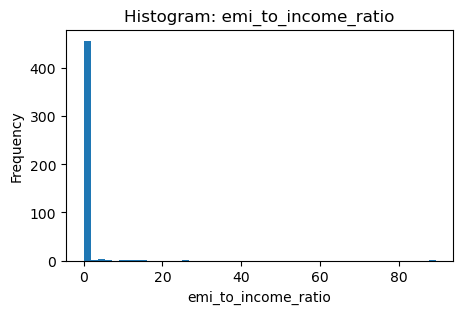

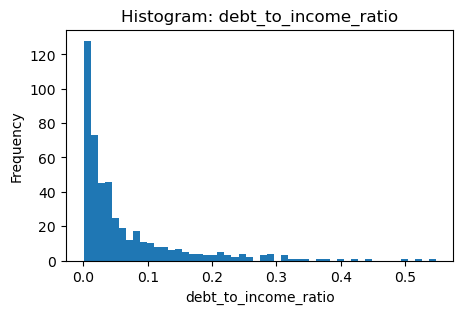

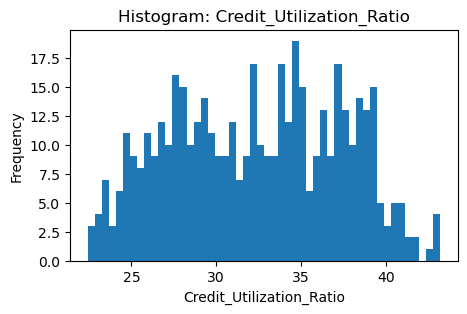

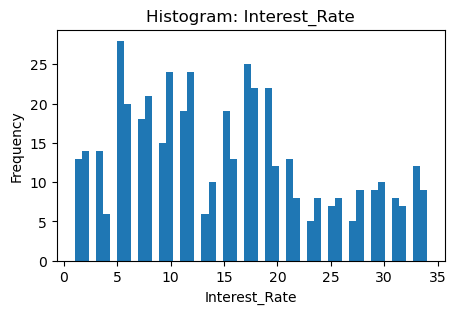

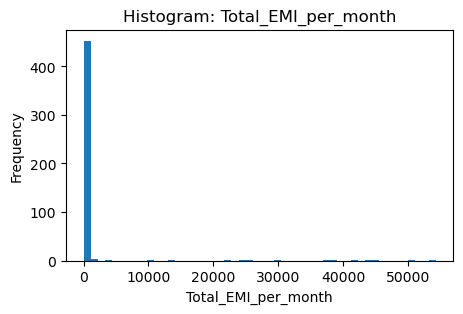

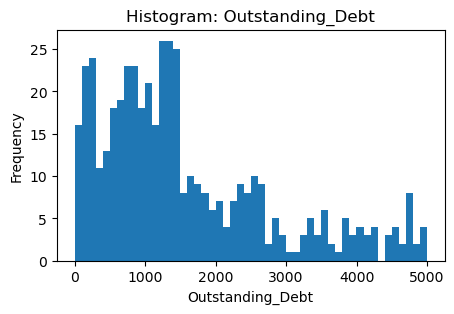

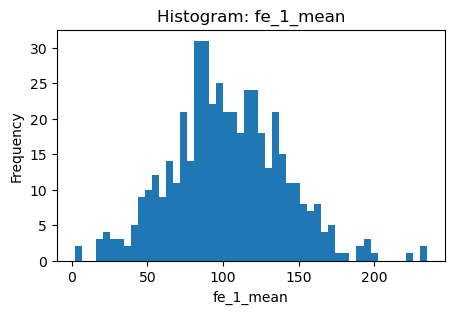

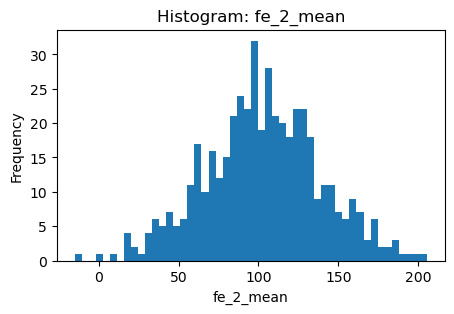

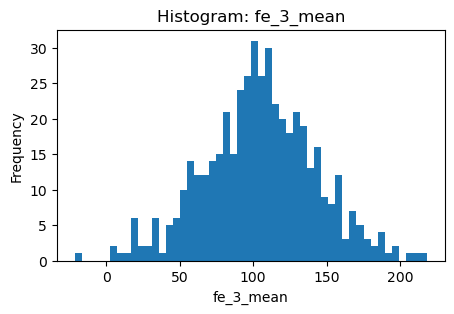

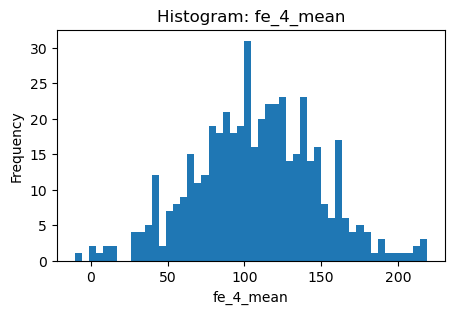

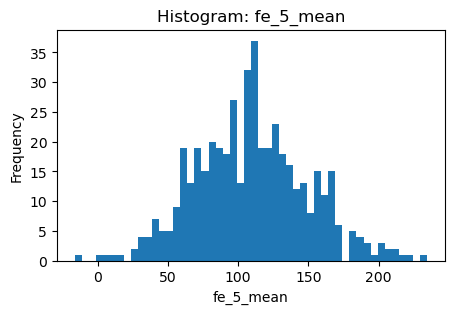

In [90]:

import matplotlib.pyplot as plt

cols_to_plot = [
    "emi_to_income_ratio",
    "debt_to_income_ratio",
    "Credit_Utilization_Ratio",
    "Interest_Rate",
    "Total_EMI_per_month",
    "Outstanding_Debt",
] + [f"fe_{i}_mean" for i in range(1, 6)]  # first 5 click means for brevity

# Convert a small sample to pandas for plotting
pdf = features_df.select(*[c for c in cols_to_plot if c in features_df.columns]).limit(5000).toPandas()

for c in pdf.columns:
    plt.figure(figsize=(5,3))
    plt.hist(pdf[c].dropna(), bins=50)
    plt.title(f"Histogram: {c}")
    plt.xlabel(c)
    plt.ylabel("Frequency")
    plt.show()


In [91]:

cat_cols = [c for c in ["Age_bin", "Occupation"] if c in features_df.columns]
for c in cat_cols:
    print(f"\n=== Value counts: {c} ===")
    vc = (
        features_df.groupBy(c).count()
        .orderBy(F.desc("count"))
        .limit(20)
        .toPandas()
    )
    display(vc)



=== Value counts: Age_bin ===


,Age_bin,count
0,35_49,172
1,25_34,143
2,18_24,96
3,50_64,34
4,None,26



=== Value counts: Occupation ===


,Occupation,count
0,Mechanic,37
1,Teacher,35
2,Architect,35
3,Lawyer,34
4,None,34
5,Engineer,34
6,Accountant,32
7,Media Manager,31
8,Scientist,30
9,Developer,30


In [92]:

issues = {}

if "Interest_Rate" in features_df.columns:
    gt100 = features_df.filter(F.col("Interest_Rate") > 100).count()
    issues["Interest_Rate>100"] = gt100

if "Credit_Utilization_Ratio" in features_df.columns:
    gt1 = features_df.filter(F.col("Credit_Utilization_Ratio") > 1).count()
    lt0 = features_df.filter(F.col("Credit_Utilization_Ratio") < 0).count()
    issues["Credit_Utilization_Ratio>1"] = gt1
    issues["Credit_Utilization_Ratio<0"] = lt0

print("Sanity range issues:", issues)


Sanity range issues: {'Interest_Rate>100': 0, 'Credit_Utilization_Ratio>1': 471, 'Credit_Utilization_Ratio<0': 0}


In [93]:

'''out_csv = f"pretrain_gold_sample_{SNAPSHOT_DATE.replace('-', '')}.csv"
sample_pdf = features_df.limit(200).toPandas()
sample_pdf.to_csv(out_csv, index=False)
print("Saved sample to:", out_csv)'''


'out_csv = f"pretrain_gold_sample_{SNAPSHOT_DATE.replace(\'-\', \'\')}.csv"\nsample_pdf = features_df.limit(200).toPandas()\nsample_pdf.to_csv(out_csv, index=False)\nprint("Saved sample to:", out_csv)'

In [94]:

# spark.stop()  # Uncomment to stop Spark when you finish the audit
